In [1]:
# GENERAL IMPORTS
import cv2
from matplotlib import pyplot as plt
import numpy as np
import glob
import os
from pprint import pprint
# from collections import deque
from time import time

# FILE IMPORTS
from config_file import Config

conf = Config()
ROOT_DIR = os.path.dirname(os.path.abspath(os.getcwd()))

In [2]:
folders = glob.glob(os.path.join(ROOT_DIR, "data", "stereodataset", "*"))
N_IMAGES = len(folders)

dataset = []

for folder in folders:
    with open(os.path.join(folder, "param_in.txt")) as f:
        params = f.readlines()
        data = {
            "name": os.path.abspath(folder),
            "ref": params[0].split(" ")[1].strip(),
            "gt": params[1].split(" ")[1].strip(),
            "disp_min": int(params[3].split(" ")[1].strip()),
            "disp_max": int(params[4].split(" ")[1].strip()),
            "disp_scale": int(params[5].split(" ")[1].strip()),
            "ignore_border": int(params[7].split(" ")[1].strip())
        }

        data["disp_range"] = range(data["disp_min"], data["disp_max"])
        dataset.append(data)


def display_img_standard(img):
    if len(img.shape) == 3:
        plt.imshow(img)
    else:
        plt.imshow(img, cmap="gray", vmin=0, vmax=np.max(img))
         

def read_image(path):
        print("img path {}".format(path))
    # if path.split(".")[-1] == "pgm":
        img = cv2.imread(path, -1)
        print(img.shape)
        plt.figure(figsize=(5,3))
        if len(img.shape) == 2:
            plt.imshow(img, cmap="gray", vmin=0, vmax=255)
        else:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show()
        return img


/home/franchetto4/github/ComputerVision/data/stereodataset/map
img path /home/franchetto4/github/ComputerVision/data/stereodataset/map/im1.pgm
(216, 284)


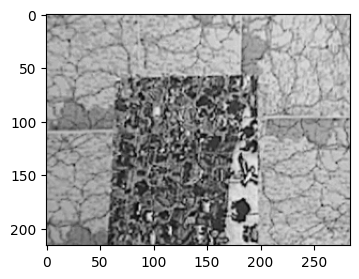

img path /home/franchetto4/github/ComputerVision/data/stereodataset/map/im0.pgm
(216, 284)


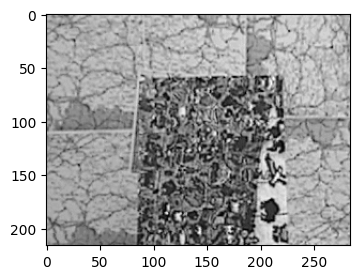

img path /home/franchetto4/github/ComputerVision/data/stereodataset/map/disp1.pgm
(216, 284)


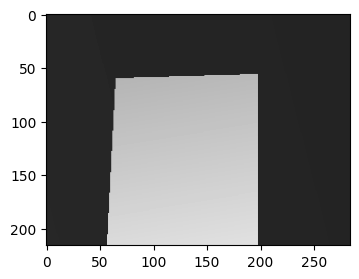

/home/franchetto4/github/ComputerVision/data/stereodataset/venus
img path /home/franchetto4/github/ComputerVision/data/stereodataset/venus/im6.ppm
(383, 434, 3)


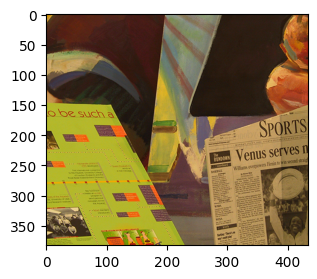

img path /home/franchetto4/github/ComputerVision/data/stereodataset/venus/im2.ppm
(383, 434, 3)


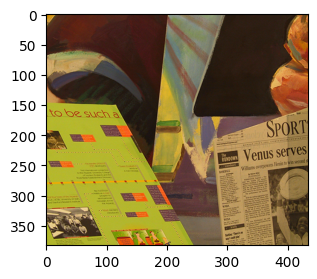

img path /home/franchetto4/github/ComputerVision/data/stereodataset/venus/disp6.pgm
(383, 434)


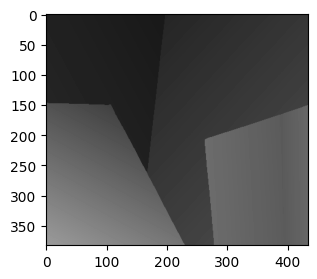

/home/franchetto4/github/ComputerVision/data/stereodataset/sawtooth
img path /home/franchetto4/github/ComputerVision/data/stereodataset/sawtooth/im6.ppm
(380, 434, 3)


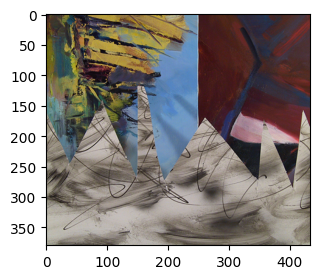

img path /home/franchetto4/github/ComputerVision/data/stereodataset/sawtooth/im2.ppm
(380, 434, 3)


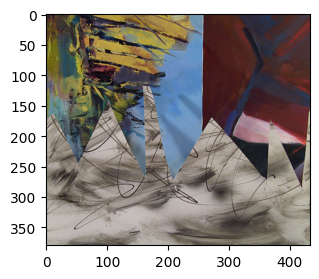

img path /home/franchetto4/github/ComputerVision/data/stereodataset/sawtooth/disp6.pgm
(380, 434)


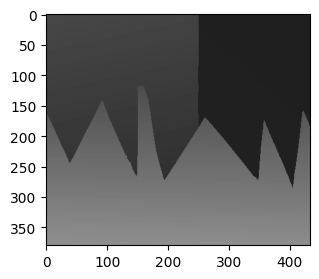

/home/franchetto4/github/ComputerVision/data/stereodataset/tsukuba
img path /home/franchetto4/github/ComputerVision/data/stereodataset/tsukuba/scene1.row3.col3.ppm
(288, 384, 3)


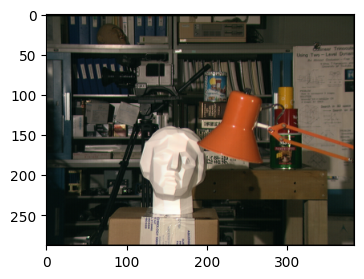

img path /home/franchetto4/github/ComputerVision/data/stereodataset/tsukuba/scene1.row3.col2.ppm
(288, 384, 3)


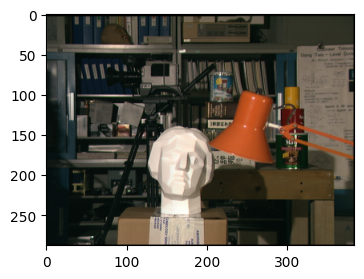

img path /home/franchetto4/github/ComputerVision/data/stereodataset/tsukuba/truedisp.row3.col3.pgm
(288, 384)


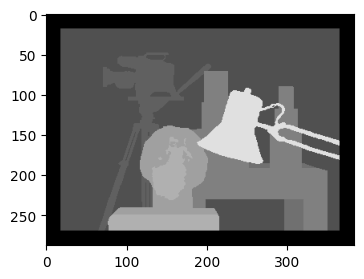

In [3]:
for i, data in enumerate(dataset):
    print(data["name"])

    left_img_full_path = os.path.join(folders[i], data["ref"])
    data["left_img"] = read_image(left_img_full_path)

    left_img_path = data["ref"]
    init_char = left_img_path[0]
    extension = left_img_path.split(".")[-1]
    right_img_format = init_char + "*." + extension
    right_img_path = glob.glob(os.path.join(folders[i], right_img_format))
    right_img_path.remove(left_img_full_path)
    if len(right_img_path) > 1:
        raise ValueError("Too many images with format {}".format(right_img_format))
    else:
        right_img_path = right_img_path[0]

    data["right_img"] = read_image(right_img_path)
    
    data["disp_map_gt"] = read_image(os.path.join(folders[i], data["gt"]))


In [4]:
def pad_to_img_size(img, monochannel_img):
    h, w = img.shape[:2]
    h_m, w_m = monochannel_img.shape

    if h-h_m == w-w_m:
        pad_size = int((h-h_m) / 2)
    else:
        raise ValueError("Mask is not smaller by the same constant in height and width wrt the image")

    return np.pad(monochannel_img, pad_size)

In [54]:
def check_img_channels(img1, img2) -> bool:
    '''
    Returns True if both are RGB, False is grayscale, raises an error otherwise
    '''
    if len(img1.shape) != len(img2.shape):
        raise ValueError("The two images mush have the same numbero of channels: img1 shape = {} and img2 shape = {}".format(img1.shape, img2.shape))
    elif len(img1.shape) == 3:
        if img1.shape[-1] == 3:
            rgb_flag = True
        elif img1.shape[-1] == 1:
            rgb_flag = False
        else:
            raise ValueError("The images can either have 3 channels (RGB) or 1 (grayscale): # of channels of img1 = {}".format(img1.shape[-1]))
        
    return rgb_flag


def dis_similarity_func(mode, img1, img2, k, disparity_range, search_area=None, zero_meaned=False):
    '''
    Returns a matrix [h-2k, w-2k, d] with NCC value for each pixel and disparity in disparity range
    You will need to compute at least a np.max on the last axis to use it
    '''
    img1 = np.copy(img1)
    img2 = np.copy(img2)

    # compute the Normalized Cross Correlation
    #  between intensities of the two images
    # in disparity map computation you only need to compare the left pixel (and patch around it) with an horizontal segment in the right image (the disparity_range)
    if mode not in ["SAD", "SSD", "NCC"]:
        raise NotImplementedError("The '{}' (dis)similarity function has not been implemented yet".format(mode))
    
    if search_area is not None:
        i_min, i_max, j_min, j_max = search_area
    else:
        h, w = img1.shape[:2]
        i_min = k
        i_max = h-k
        j_min = k
        j_max = w-k

    up_lim =    i_min-k
    down_lim =  i_max+k+1
    left_lim =  j_min-k
    right_lim = j_max+k+1

    disparity_maps = np.zeros((i_max-i_min, j_max-j_min, len(disparity_range)))

    if zero_meaned:
        mean_filter = np.ones((k,k)) / (k*k)
        means_img1 = cv2.filter2D(img1, -1, mean_filter, (-1, -1))
        means_img2 = cv2.filter2D(img2, -1, mean_filter, (-1, -1))
        img1 = (img1 - means_img1)
        img2 = (img2 - means_img2)
        
    img1_area = img1[up_lim:down_lim, left_lim:right_lim, ...]
    if mode == "NCC":
        img1_area_squared = np.square(img1_area, dtype=np.int64)
        tmp_denom1 = cv2.filter2D(img1_area_squared, -1, np.ones((k,k)), (-1,-1))
        tmp_denom1 = tmp_denom1[i_min:i_max, j_min:j_max, ...]

    for d in disparity_range:
        # for some pixels with high "j", high disparity numbers would bring the patch outside the image
        img2_area = img2[ up_lim:down_lim, left_lim+(d):right_lim+(d),   ...]
        
        if img2_area.shape != img1_area.shape: # if the above happens, we pad with zeros
            if right_lim+(d) > w:
                pad_size = right_lim+(d) - w
                padded_img2_area = np.zeros_like(img1_area)
                padded_img2_area[:, :-pad_size+1, ...] = img2_area
            elif left_lim+(d) < 0:
                # if we are doing a Right-Left consistency check, the disparity will be negative
                pad_size = - (left_lim+(d))
                padded_img2_area = np.zeros_like(img1_area)
                padded_img2_area[:, pad_size:, ...] = img2_area

            img2_area = padded_img2_area

        if mode == "SAD":
            disparity_pixelwise = np.abs(img1_area - img2_area, dtype=np.int64)
        elif mode == "SSD":
            disparity_pixelwise = np.square(img1_area - img2_area, dtype=np.int64)
        elif mode == "NCC":
            disparity_pixelwise = np.multiply(img1_area, img2_area, dtype=np.int64)

            img2_area_squared = np.square(img2_area, dtype=np.int64)
            tmp_denom2 = cv2.filter2D(img2_area_squared, -1, np.ones((k,k)), (-1,-1))
            tmp_denom2 = tmp_denom2[i_min:i_max, j_min:j_max, ...]

            denom = np.sqrt(np.multiply(tmp_denom1, tmp_denom2, dtype=np.float64))

        # compute the sum over the patches (and over the channels if RGB)
        tmp = cv2.filter2D(disparity_pixelwise, -1, np.ones((k,k)), (-1,-1))
        tmp = tmp[i_min:i_max, j_min:j_max, ...]

        if mode == "NCC":
            tmp = np.divide(tmp, denom)
        
        if len(tmp.shape) == 3:
            tmp = np.sum(tmp, axis=-1)
        
        disparity_maps[:, :, np.abs(d)] = tmp # abs needed because R_L_consistency_check has negative d values

    return disparity_maps

In [6]:
# need to compute the min along disparity axis to find disparity for each pixel
disparity_maps = dis_similarity_func("SAD", dataset[0]["left_img"], dataset[0]["right_img"], k=19, disparity_range=conf.d_range)
dataset[0]["disp_function_SAD"] = disparity_maps
disparity_map = np.argmin(disparity_maps, axis=-1)

In [7]:
np.max(disparity_maps)

78113.0

In [8]:
def show_disp_and_imgs(img1, img2, disparity_map, name=""):
    fig, axs = plt.subplots(1, 3, figsize=(12, 5), constrained_layout=True)

    fig.suptitle(name, fontsize=15)

    axs[0].axis("off")
    axs[0].set_title("left_img")
    if len(img1.shape) == 2:
        axs[0].imshow(img1, cmap="gray", vmin=0, vmax=255)
    else:
        axs[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))

    axs[1].axis("off")
    axs[1].set_title("right_img")
    if len(img2.shape) == 2:
        axs[1].imshow(img2, cmap="gray", vmin=0, vmax=255)
    else:
        axs[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

    axs[2].axis("off")
    axs[2].set_title("disparity_map")
    axs[2].imshow(disparity_map, cmap="gray", vmin=0, vmax=len(conf.d_range))
    plt.show()

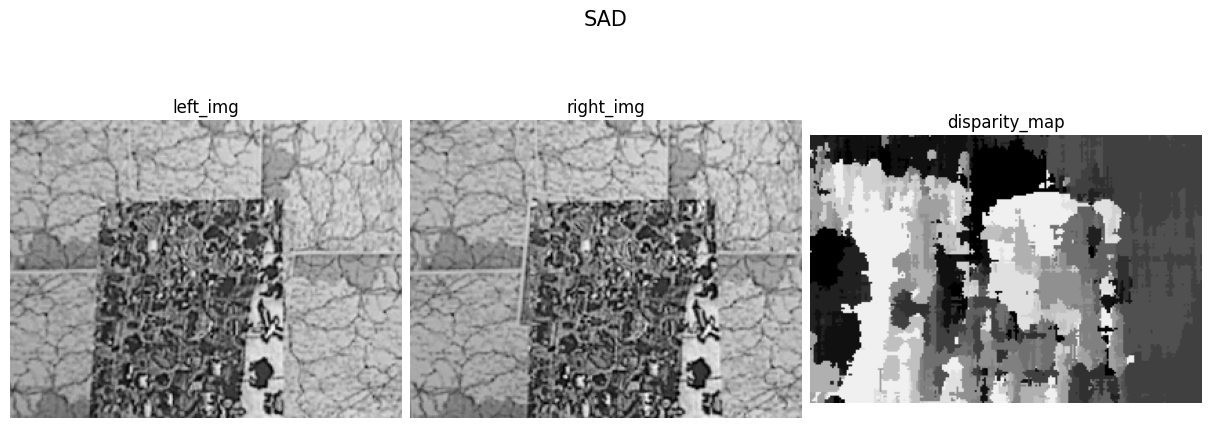

In [9]:
disparity_maps = dis_similarity_func("SAD", dataset[0]["left_img"], dataset[0]["right_img"], k=35, disparity_range=conf.d_range)
disparity_map = np.argmin(disparity_maps, axis=-1)
show_disp_and_imgs(dataset[0]["left_img"], dataset[0]["right_img"], disparity_map, "SAD")

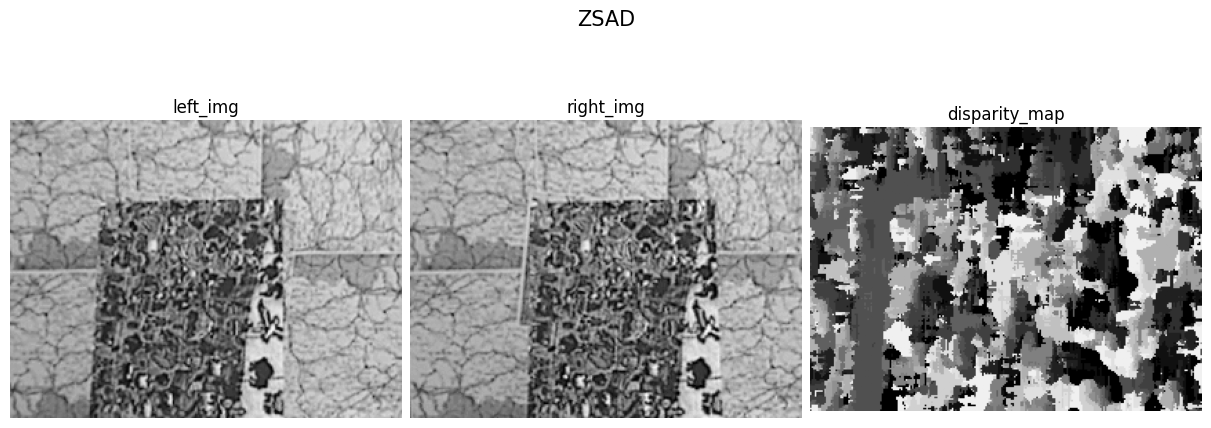

In [10]:
disparity_maps = dis_similarity_func("SAD", dataset[0]["left_img"], dataset[0]["right_img"], k=19, disparity_range=conf.d_range, zero_meaned=True)
disparity_map = np.argmin(disparity_maps, axis=-1)
show_disp_and_imgs(dataset[0]["left_img"], dataset[0]["right_img"], disparity_map, "ZSAD")

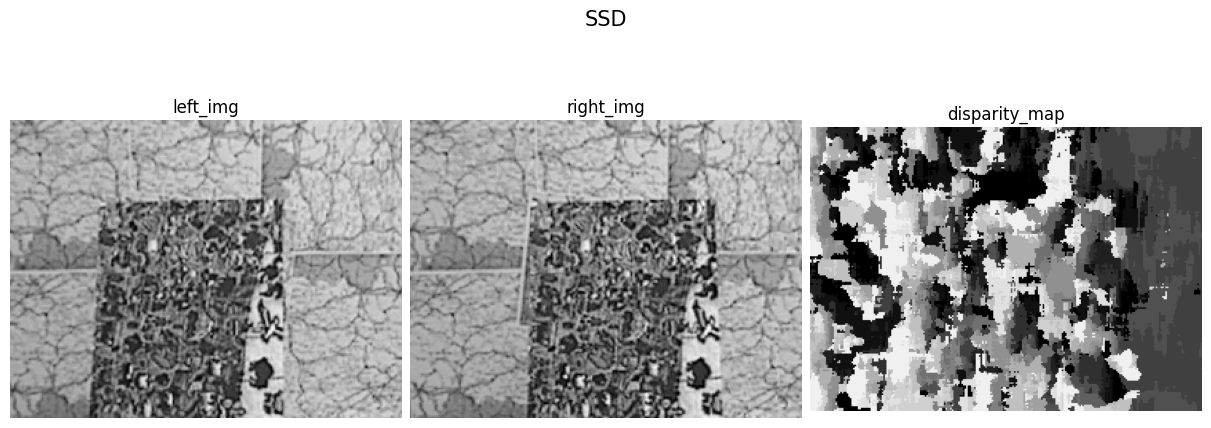

In [11]:
disparity_maps = dis_similarity_func("SSD", dataset[0]["left_img"], dataset[0]["right_img"], k=19, disparity_range=conf.d_range)
disparity_map = np.argmin(disparity_maps, axis=-1)
show_disp_and_imgs(dataset[0]["left_img"], dataset[0]["right_img"], disparity_map, "SSD")

9484292.479991665


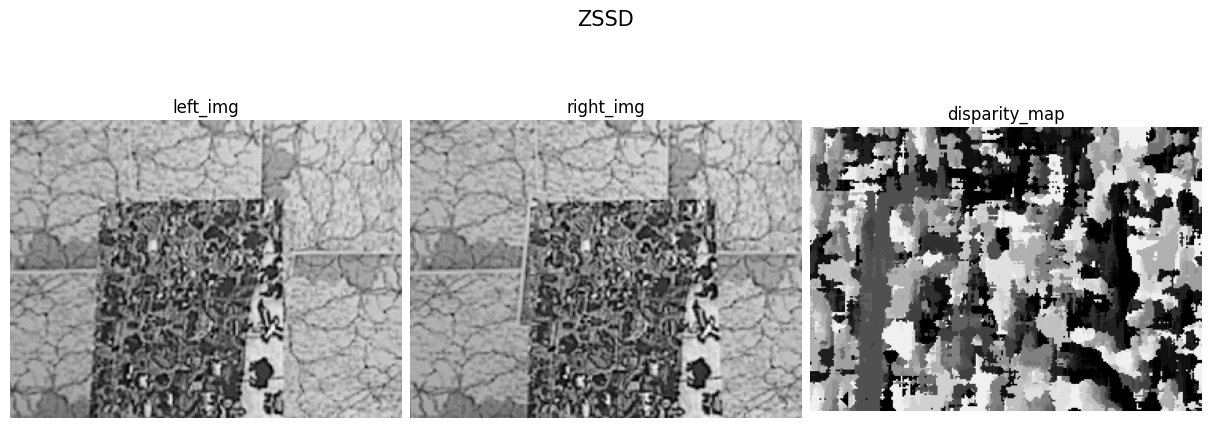

In [12]:
disparity_maps = dis_similarity_func("SSD", dataset[0]["left_img"], dataset[0]["right_img"], k=19, disparity_range=conf.d_range, zero_meaned=True)
print(np.mean(disparity_maps))
disparity_map = np.argmin(disparity_maps, axis=-1)
show_disp_and_imgs(dataset[0]["left_img"], dataset[0]["right_img"], disparity_map, "ZSSD")

0.9220667014862624


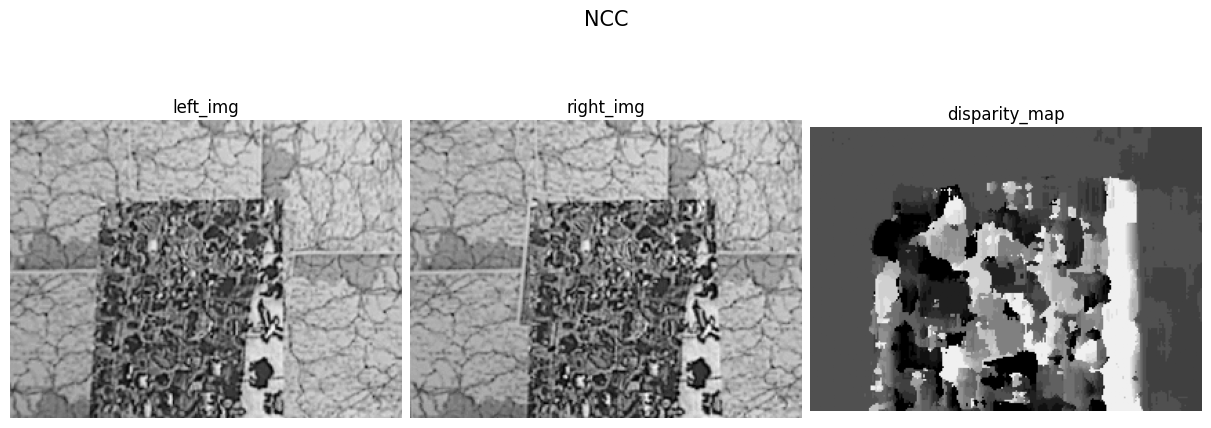

In [13]:
disparity_maps = dis_similarity_func("NCC", dataset[0]["left_img"], dataset[0]["right_img"], k=19, disparity_range=conf.d_range)
print(np.mean(disparity_maps))
disparity_map = np.argmax(disparity_maps, axis=-1)
show_disp_and_imgs(dataset[0]["left_img"], dataset[0]["right_img"], disparity_map, "NCC")

0.5989782723183373


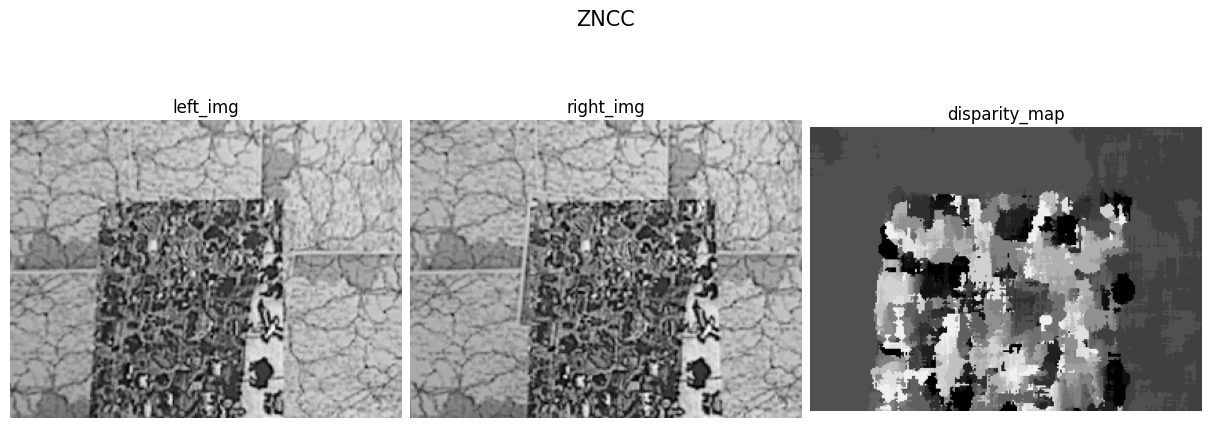

In [14]:
disparity_maps = dis_similarity_func("NCC", dataset[0]["left_img"], dataset[0]["right_img"], k=19, disparity_range=conf.d_range, zero_meaned=True)
print(np.mean(disparity_maps))
disparity_map = np.argmax(disparity_maps, axis=-1)
show_disp_and_imgs(dataset[0]["left_img"], dataset[0]["right_img"], disparity_map, "ZNCC")

In [15]:
def evaluation_dense(gt, prediction, disp_scale, ignore_border=0):
    '''
    Better when LOWER
    eval = mean "correctness", where correctness of a disparity measure is 0 if the error is <= 1, 1 otherwise
    '''
    # reduce the gt disparity_map by its scale
    gt = gt/float(disp_scale)
    prediction = pad_to_img_size(gt, prediction)
    h, w = gt.shape[:2]
    b = ignore_border
    difference = np.abs(gt[b:h-b+1, b:w-b+1] - prediction[b:h-b+1, b:w-b+1]) - 1 # min_value is -1
    
    difference = np.minimum(difference, 1) # cap the image to max_value = 1
    difference = np.maximum(difference, 0) # cap the image to min_value = 0
    plt.imshow(difference, cmap="gray", vmin=0, vmax=1)
    return 1-np.mean(difference)

0.5169294099020649

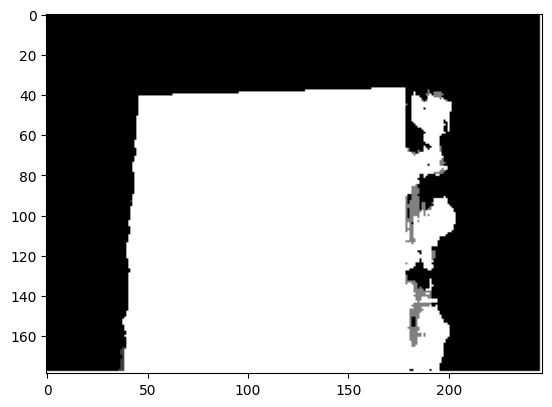

In [16]:
evaluation_dense(dataset[0]["disp_map_gt"], disparity_map, disp_scale=dataset[0]["disp_scale"], ignore_border=19)

In [17]:
def moravec(img):
    '''
    Returns "cornerness" of each pixel through the moravec operator
    The returned matrix is reduced on all sides by 1 pixel, because moravec operator
    '''
    directional_differences = []
    h,w = img.shape[:2]
    for m in range(-1, 2):
        for n in range(-1, 2):
            if m == 0 and n == 0:
                pass
            else:
                difference = np.square(img[1:-1, 1:-1, ...] - img[1+m:h-1+m, 1+n:w-1+n, ...])
                if len(img.shape) == 3:
                    # check (1+m:-1+m --> not always negative)
                    difference = np.sum(difference, axis=-1)

                directional_differences.append(difference)

    directional_differences = np.stack(directional_differences, axis=-1)
    min_difference = np.min(directional_differences, axis=-1)

    return min_difference


def get_moravec_mask(img, minimum_interestingness_threshold):
    img_interestingness = moravec(img)
    return img_interestingness > minimum_interestingness_threshold

Black = rejected
Percentage accepted = 0.3004739179425996


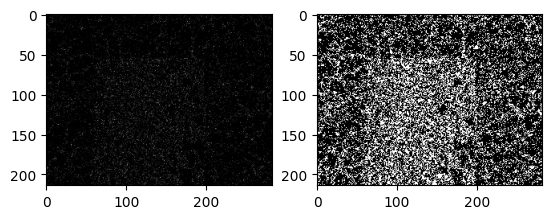

In [18]:
plt.subplot(121)
plt.imshow(moravec(dataset[0]["left_img"]), cmap="gray", vmin=0, vmax=255)
plt.subplot(122)

mask = get_moravec_mask(dataset[0]["left_img"], 1)

print("Black = rejected")
print("Percentage accepted = {}".format(np.mean(mask)))
plt.imshow(mask, cmap="gray", vmin=0, vmax=1)
plt.show()

dataset[0]["interest_mask"] = mask

In [19]:
def find_critical_points(arr, find_minimum):
    deriv = arr[1:] - arr[:-1]
    
    if not find_minimum:
        mask_left_deriv = np.concatenate([np.array([True]), deriv>0]) # add a true because we want to allow LAST value to be "peak" 
        mask_right_deriv = np.concatenate([deriv<0, np.array([True])]) # add a true because we want to allow LAST value to be "peak" 
    else:
        mask_left_deriv = np.concatenate([np.array([True]), deriv<0]) # add a true because we want to allow LAST value to be "peak" 
        mask_right_deriv = np.concatenate([deriv>0, np.array([True])]) # add a true because we want to allow LAST value to be "peak" 
    
    is_peak = np.multiply(mask_left_deriv, mask_right_deriv)
    return is_peak, deriv

In [20]:
a = np.array([8, 4, 2, 6, -3])
is_peak, deriv = find_critical_points(a, find_minimum=False)
is_peak

array([ True, False, False,  True, False])

In [35]:
def get_disparity_mask(disparity_map, th_ratio, th_derivative, find_minimum):
    '''
    Returns a boolean mask with 0 if a pixel doesn't have a "good" maximum in its disparity values,
    1 otherwise
    '''
    h, w = disparity_map.shape[:2]
    disparity_mask = np.ones((h, w))

    
    c1, c2 = 0, 0
    for i in range(h):
        for j in range(w):
            disparities = disparity_map[i, j, :]
            disparities /= np.max(disparities) # normalizing so it works both for NCC and SAD/SSD

            is_critical_point, deriv = find_critical_points(disparities, find_minimum)
            crit_points = list(np.multiply(disparities, is_critical_point))

            if find_minimum:
                crit_point_1_idx = np.argmin(crit_points)

                crit_point_1_value = crit_points[crit_point_1_idx]
                crit_points[crit_point_1_idx] = 0

                crit_point_2_value = np.min(crit_points)

            else:
                crit_point_1_idx = np.argmax(crit_points)

                crit_point_1_value = crit_points[crit_point_1_idx]
                crit_points[crit_point_1_idx] = 0

                crit_point_2_value = np.max(crit_points)

            if np.abs(crit_point_2_value/crit_point_1_value -1) < (1-th_ratio):
                # np.abs(p2/p1 - 1) is "how much is the second critical point different from the first"
                # to DISCARD them, we need that this difference is SMALLER than our threshold
                disparity_mask[i, j] = 0
                c1+=1
            
            if crit_point_1_idx == 0:
                if np.abs(deriv[0]) < th_derivative:
                    c2+=1
                    disparity_mask[i, j] = 0
            elif crit_point_1_idx == len(disparities)-1:
                if np.abs(deriv[-1]) < th_derivative:
                    c2+=1
                    disparity_mask[i, j] = 0
            else:
                if np.abs(deriv[crit_point_1_idx-1]) + np.abs(deriv[crit_point_1_idx]) < 2*th_derivative:
                    disparity_mask[i, j] = 0
                    c2+=1

    # print("Black = rejected. \n"+\
    #         "Total points = {} \n".format(h*w)+\
    #         "Rejected because ratio 2nd/1st peak too high {} \n".format(c1)+\
    #         "Rejected because bad peak spread {}".format(c2))
            
    return disparity_mask

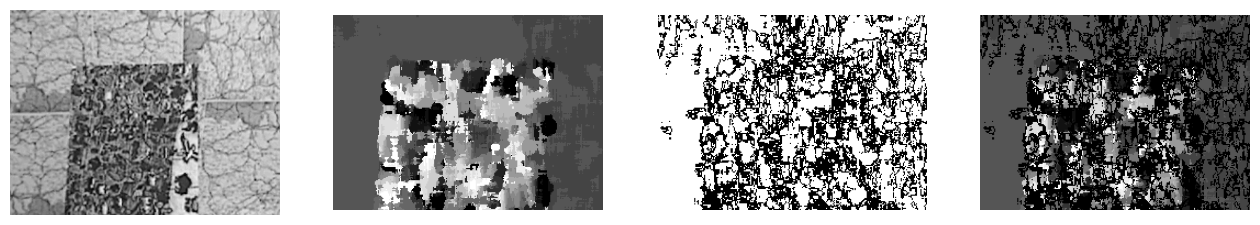

In [36]:
plt.figure(figsize=(16, 9))
plt.subplot(141)
plt.axis("off")
display_img_standard(dataset[0]["left_img"])
plt.subplot(142)
plt.axis("off")
disparity_maps = dis_similarity_func("NCC", dataset[0]["left_img"], dataset[0]["right_img"], k=19, disparity_range=conf.d_range, zero_meaned=True)
disparity_map = np.argmax(disparity_maps, axis=-1)
display_img_standard(disparity_map)
plt.subplot(143)
plt.axis("off")
disparity_mask = get_disparity_mask(dataset[0]["disp_function_SAD"], 0.98, 0.01, False)
display_img_standard(disparity_mask)
plt.subplot(144)
plt.axis("off")
display_img_standard(np.multiply(disparity_map, disparity_mask))
plt.show()

In [37]:
dataset[0]["disp_mask"] = disparity_mask
pprint(list(np.sort(list(dataset[0].keys()))))

['disp_function_SAD',
 'disp_map_gt',
 'disp_mask',
 'disp_max',
 'disp_min',
 'disp_range',
 'disp_scale',
 'disparity_function',
 'gt',
 'ignore_border',
 'interest_mask',
 'left_img',
 'name',
 'ref',
 'right_img']


In [52]:
def evaluation_sparse(gt_disparity, prediction_disparity, disp_scale, masks=[], ignore_border=0, show_imgs=False):
    '''
    Returns mean correctness of disparity prediction taking into account ONLY:
        - interest_mask: the pixels of the image on which we want to compute disparity
        - disparity_mask: the pixels of the image in which the disparity maximum was accepted
    '''
    # pads all the inputs to the gt_disparity shape, so that multiplication works well
    h, w = gt_disparity.shape[:2]
    b = ignore_border
    gt_disparity = gt_disparity/float(disp_scale)
    prediction_disparity = pad_to_img_size(gt_disparity, prediction_disparity)
    
    rejected_pixels = {}
    area_without_borders = (h-2*b)*(w-2*b)
    pixels_excluded_by_border = (h*w) - area_without_borders

    if len(masks) != 0:
        for mask_type in masks:
            masks[mask_type] = pad_to_img_size(gt_disparity, masks[mask_type])
            masks[mask_type] = masks[mask_type].astype(np.bool8)
            rejected_pixels[mask_type] = area_without_borders-np.sum(masks[mask_type][b:h-b+1, b:w-b+1])
    
        final_mask = np.prod(np.stack(list(masks.values())), axis=0)
    else:
        final_mask = np.ones_like(gt_disparity)

    final_mask = final_mask[b:h-b+1, b:w-b+1]
    accepted_pixels_inside_border = np.sum(final_mask)

    difference = np.abs(gt_disparity[b:h-b+1, b:w-b+1] - prediction_disparity[b:h-b+1, b:w-b+1]) - 1
    difference = np.minimum(difference, 1) 
    difference = np.maximum(difference, 0)

    final_difference_gt_pred = np.multiply(difference, final_mask)

    if show_imgs:
        # difference = 1 --> wrong prediction
        # difference = 0 --> right prediction
        plt.subplot(131)
        display_img_standard(difference)
        plt.subplot(132)
        display_img_standard(final_mask)
        plt.subplot(133)
        display_img_standard(final_difference_gt_pred)

    accuracy = 1 - (np.sum(final_difference_gt_pred) / accepted_pixels_inside_border)
    accepted_pixels_percentage = accepted_pixels_inside_border / (h*w)

    sum_masks = np.sum([rejected_pixels[m] for m in rejected_pixels])
    
    for m in rejected_pixels:
        rejected_pixels[m] *= ((area_without_borders - accepted_pixels_inside_border)/sum_masks) # normalized (they could reject the same pixel)
    
    rejected_pixels["border"] = pixels_excluded_by_border

    for m in rejected_pixels:
        rejected_pixels[m] /= (w*h) # normalized by total area

    return accuracy, accepted_pixels_percentage, rejected_pixels, \
        final_mask, prediction_disparity, final_difference_gt_pred

0.20303254437869822 0.1322378716744914
{'border': 0.0,
 'disp_mask': 0.3825981379121978,
 'interest_mask': 0.4851639904133108}


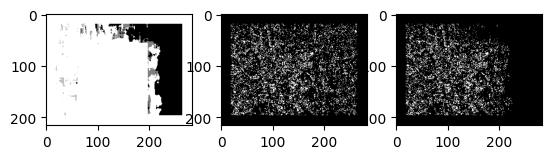

In [39]:
accuracy, accepted_pixels_perc, rejected_pixels, final_mask, prediction_disparity, disparity_difference_wrt_gt = evaluation_sparse(dataset[0]["disp_map_gt"], 
                                                   np.argmin(dataset[0]["disp_function_SAD"], axis=-1), 
                                                   dataset[0]["disp_scale"],
                                                   {"interest_mask":dataset[0]["interest_mask"], "disp_mask":dataset[0]["disp_mask"]}, 
                                                   dataset[0]["ignore_border"],
                                                   show_imgs=True)
print(accuracy, accepted_pixels_perc)
pprint(rejected_pixels)

In [40]:
def filter_img(img, mode, **kwargs):
    if mode == "mean":
        k = kwargs["kernel_size"]
        return cv2.filter2D(img, -1, np.ones((k,k))/(k*k), (-1,-1))
    elif mode == "gauss":
        k = kwargs["kernel_size"]
        sigma = kwargs["sigma"]
        return cv2.GaussianBlur(img, (k,k), sigma)
    elif mode == "bilateral":
        k = kwargs["kernel_size"]
        sigma_color = kwargs["sigma_color"]
        sigma_spatial = kwargs["sigma_spatial"]
        return cv2.bilateralFilter(img, k, sigma_color, sigma_spatial)
    elif mode == "LOG":
        raise NotImplementedError("TODO: IMPLEMENT")
    else:
        raise NotImplementedError("'{}' filtering mode is not implemented yet".format(mode))

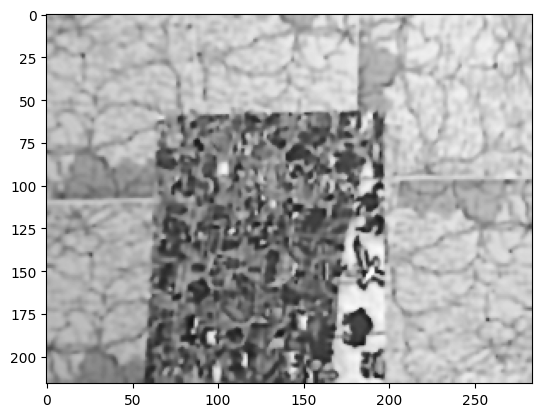

In [41]:
display_img_standard(filter_img(dataset[0]["left_img"], "bilateral", kernel_size=5, sigma_color=50, sigma_spatial=90))

In [42]:
def display_img_and_masks(img, masks):
    plt.figure(figsize = (16, 9))
    subplot_len = 1+len(masks)
    print("Masks: {}".format(masks.keys()))
    plt.subplot(1, subplot_len, 1)
    display_img_standard(img)

    for i, mask in enumerate(masks):
        plt.subplot(1, subplot_len, 2+i)
        display_img_standard(masks[mask])

    plt.show()


In [50]:
def evaluation_pipeline(
        dataset,
        general_dis_similarity_function,
        dis_similarity_mode,
        patch_size,
        search_area = None,
        zero_meaned = False,
        filtering_mode = None, # "mean", "gauss", "bilateral"
        apply_moravec = False,
        moravec_threshold = 0,
        study_disparity_function = False,
        disparity_ratio_threshold = 0,
        disparity_derivative_threshold = 0,
        left_right_consistency_check = False,
        verbose_graphical = False,
        **kwargs
        ):
    
    accuracies = []
    disp_densities = []
    rejected_pixels_list = []

    init_time = time()

    for data in dataset:
        img1=data["left_img"]
        img2=data["right_img"]
        
        if filtering_mode is not None:
            img1 = filter_img(img1, filtering_mode, **kwargs)
            img2 = filter_img(img2, filtering_mode, **kwargs)

        masks = {}

        if apply_moravec:
            masks["moravec"] = get_moravec_mask(img1, moravec_threshold)

        data["disparity_function"] = general_dis_similarity_function(
            dis_similarity_mode, img1=img1, img2=img2, k=patch_size, 
            disparity_range=data["disp_range"], search_area=search_area, 
            zero_meaned=zero_meaned
        )

        if dis_similarity_mode == "SAD" or dis_similarity_mode == "SSD":
            find_minimum = True
            disparity_map = np.argmin(data["disparity_function"], axis=-1)
        elif dis_similarity_mode == "NCC":
            find_minimum = False
            disparity_map = np.argmax(data["disparity_function"], axis=-1)

        if study_disparity_function:

            masks["disparity_study"] = get_disparity_mask(
                data["disparity_function"], disparity_ratio_threshold, 
                disparity_derivative_threshold, find_minimum
            )

        if left_right_consistency_check:
            h, w = disparity_map.shape[:2]

            # TODO:FLIP IMAGES 1 AND 2, do normal disparity and then flip disp map!
            R_L_disp_function = general_dis_similarity_function(
                dis_similarity_mode, img1=img2, img2=img1, k=patch_size, 
                disparity_range=(-1)*np.array(data["disp_range"]), search_area=search_area, 
                zero_meaned=zero_meaned
            )

            if dis_similarity_mode == "SAD" or dis_similarity_mode == "SSD":
                disparity_map_R_L = np.argmin(R_L_disp_function, axis=-1)
            elif dis_similarity_mode == "NCC":
                disparity_map_R_L = np.argmax(R_L_disp_function, axis=-1)

            consistency_mask = np.zeros_like(disparity_map)

            for i in range(h):
                for j in range(w):
                    pixel_j_to_check = j + disparity_map[i, j]
                    if pixel_j_to_check < w:
                        # if np.abs(disparity_map_R_L[i, pixel_j_to_check] - disparity_map[i,j]) == 0: # this is stricter
                        if np.abs(disparity_map_R_L[i, pixel_j_to_check] - disparity_map[i,j]) <= 5:
                            consistency_mask[i, j] = 1

            masks["L_R_check"] = consistency_mask

            if verbose_graphical:
                plt.figure(figsize=(16,9))
                plt.subplot(131)
                display_img_standard(disparity_map)
                plt.subplot(132)
                display_img_standard(disparity_map_R_L)
                plt.subplot(133)
                display_img_standard(consistency_mask)
                plt.show()


        accuracy, disp_density, rejected_pixels, final_mask, \
            prediction_disparity, disparity_difference_wrt_gt = evaluation_sparse(
                    data["disp_map_gt"], disparity_map, data["disp_scale"], masks,
                    ignore_border=data["ignore_border"], show_imgs=False
        )

        masks["final_mask"] = final_mask

        if verbose_graphical:
            display_img_and_masks(img1, masks)

            plt.figure(figsize=(16,9))
            plt.subplot(141)
            display_img_standard(data["disp_map_gt"])
            plt.subplot(142)
            display_img_standard(np.multiply(data["disp_map_gt"], final_mask)) ## TODO: pad??
            plt.subplot(143)
            display_img_standard(np.multiply(prediction_disparity, final_mask))
            plt.subplot(144)
            display_img_standard(disparity_difference_wrt_gt)
            plt.show()
        
        accuracies.append(accuracy)
        disp_densities.append(disp_density)
        rejected_pixels_list.append(rejected_pixels)

    time_interval = time()-init_time

    return accuracies, disp_densities, rejected_pixels_list, time_interval

/home/franchetto4/.pyenv/versions/3.7.16/envs/env-3.7.16/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


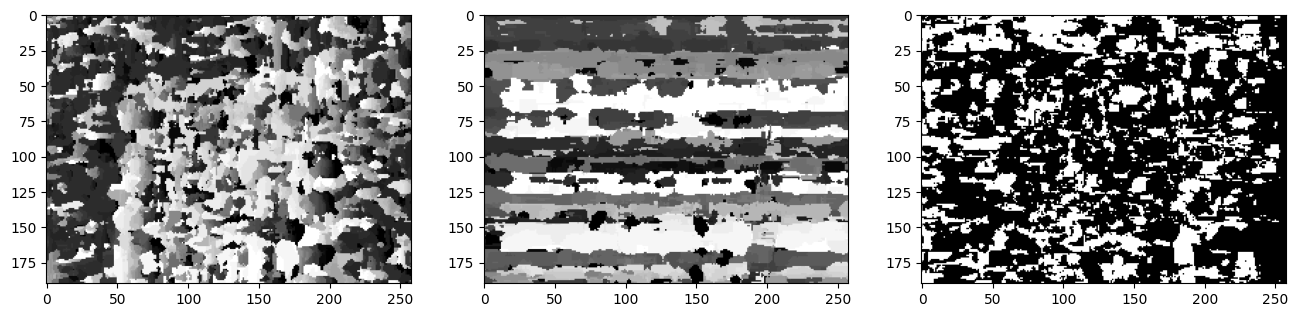

ValueError: not enough values to unpack (expected 7, got 6)

In [55]:
accuracies, disp_densities, rejected_pixels_list, time_interval = evaluation_pipeline(
    dataset,
    dis_similarity_func,
    "SAD",
    patch_size = 13,
    zero_meaned = True,
    filtering_mode = "gauss",
    kernel_size = 5,
    sigma = 1.5,
    sigma_color = 10,
    sigma_spatial = 15,
    apply_moravec = True,
    moravec_threshold = 0.9,
    study_disparity_function = True,
    disparity_ratio_threshold = 0.99,
    disparity_derivative_threshold = 0.01,
    left_right_consistency_check = True,
    verbose_graphical=True
    )

In [ ]:
pprint([accuracies, disp_densities, rejected_pixels_list, time_interval])

[[0.8686130088243667,
  0.8800750966433596,
  0.8918092647260745,
  0.8884563619422301],
 [0.4581377151799687,
  0.5695876598765507,
  0.7065728838224594,
  0.43669524016203703],
 [{'border': 0.0,
   'disparity_study': 0.13250558120167832,
   'moravec': 0.40935670361835297},
  {'border': 0.0,
   'disparity_study': 0.1168258227640151,
   'moravec': 0.31358651735943427},
  {'border': 0.0,
   'disparity_study': 0.10907494449537108,
   'moravec': 0.18435217168216952},
  {'border': 0.20703125,
   'disparity_study': 0.06831973686016177,
   'moravec': 0.2879537729778012}],
 83.98449921607971]
